# En este notebook se hace un análisis avanzado del regresor kNN con la representación vectorial word2vec

In [ ]:
# To visualize plots in the notebook
%matplotlib inline

import numpy as np
import pandas as pd # To read data tables from csv files
import seaborn as sns # To plot statistical graphics
import matplotlib.pyplot as plt # To plot the figures
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

import os
from termcolor import colored
import tqdm
import scipy
import gc
import joblib

# For plots and graphical results
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab

# That's default image size for this interactive session
pylab.rcParams['figure.figsize'] = 9, 6

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Cargar los datos desde el archivo JSON
#data_path = '/content/drive/My Drive/proyecto/full_format_recipes.json'  # Clara
data_path = '/content/drive/My Drive/Colab Notebooks/proyecto/full_format_recipes.json'  # Jorge
recipes_df = pd.read_json(data_path)

# Cargar los embeddings desde el archivo guardado
w2v_directions = np.load('/content/drive/My Drive/Colab Notebooks/proyecto/w2v_embeddings.npy')

# Verifica el tamaño de los embeddings cargados
print(f"Tamaño de los embeddings: {w2v_directions.shape}")

Mounted at /content/drive
Tamaño de los embeddings: (20130, 100)


### **1. Preparación de los datos de entrenamiento y de test**

In [ ]:
from re import X
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

target = recipes_df['rating']
print(min(target)) #0
print(max(target)) #5
target = target.fillna(target.mean()) # Relleno los valores que faltan (NaN) con media

X_train, X_test, y_train, y_test = train_test_split(w2v_directions, target, test_size=0.2, random_state=42)

# Normalizamos los datos para que tengan media cero y varianza unidad de forma
# que mejore el funcionamiento del algoritmo
scaler = StandardScaler(with_mean=False)
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Rellenar los valores NaN con la media de las etiquetas
y_train = y_train.fillna(y_train.mean())
y_test = y_test.fillna(y_test.mean())

0.0
5.0


### **2. Entrenamiento y evaluación**

#### ***2.1 Modelo de regresión con técnica de librería Scikit Learn***

Mejor valor de k: 32


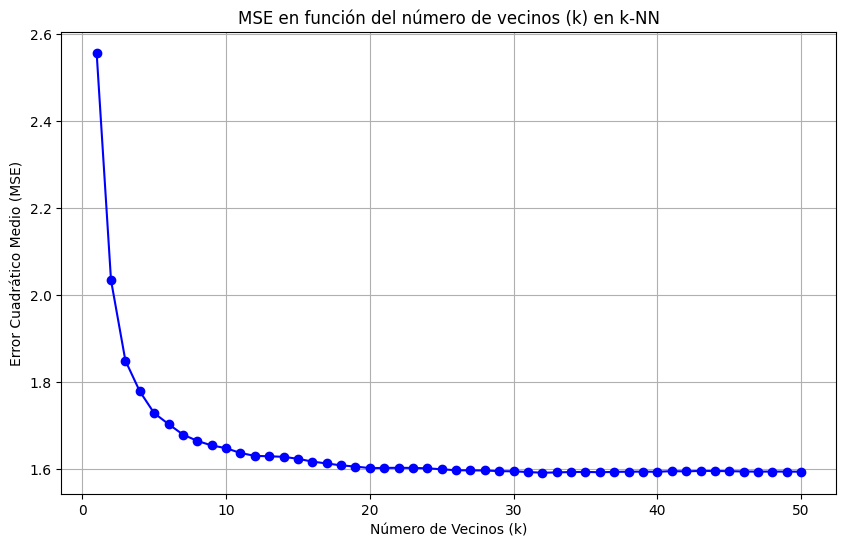

Mean Squared Error con el mejor k (32): 1.6099039197561344
R-squared con el mejor k (32): 0.10785937885051355


In [ ]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Suponiendo que ya tienes X_train y X_test
# Seleccionamos las mejores características (1000 características)
# Es recomendable normalizar las características antes de entrenar un modelo k-NN, ya que la métrica
# de distancia utilizada por k-NN se ve afectada por las escalas de las variables.

# Definimos el rango de valores de k a probar
k_values = range(1, 51)  #un valro muy grande puede llevar a undefitting

# Creamos el modelo de k-NN
knn = KNeighborsRegressor()

# Definir los parámetros a buscar
param_grid = {'n_neighbors': k_values}

# Usar GridSearchCV para encontrar el mejor valor de k
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

# Imprimir el mejor valor de k
print(f"Mejor valor de k: {grid_search.best_params_['n_neighbors']}")

# Obtener los resultados de la búsqueda para visualizar
results = grid_search.cv_results_

# Graficar la MSE para cada valor de k
plt.figure(figsize=(10, 6))
plt.plot(k_values, -results['mean_test_score'], marker='o', color='b', label="MSE")
plt.xlabel('Número de Vecinos (k)')
plt.ylabel('Error Cuadrático Medio (MSE)')
plt.title('MSE en función del número de vecinos (k) en k-NN')
plt.grid(True)
plt.show()

# Entrenar el modelo k-NN con el mejor valor de k
best_k = grid_search.best_params_['n_neighbors']
model = KNeighborsRegressor(n_neighbors=best_k)
model.fit(X_train, y_train)

# Predicciones y evaluación
y_pred = model.predict(X_test)

# Evaluar rendimiento
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error con el mejor k ({best_k}):", mse)
print(f"R-squared con el mejor k ({best_k}):", r2)

In [ ]:
#nos quedamos con k=20 ya que ya es un valor bastante bueno de MSE , valores más grandes de k no dan mejores resultados,
#pero también debes considerar que un k demasiado alto podría llevar a underfitting (es decir, el modelo se vuelve demasiado simple y no
#captura la complejidad de los datos).

Resultados con k = 20:
Mean Squared Error con k=20: 1.6136938513606756
R-squared con k=20: 0.10575915914528944


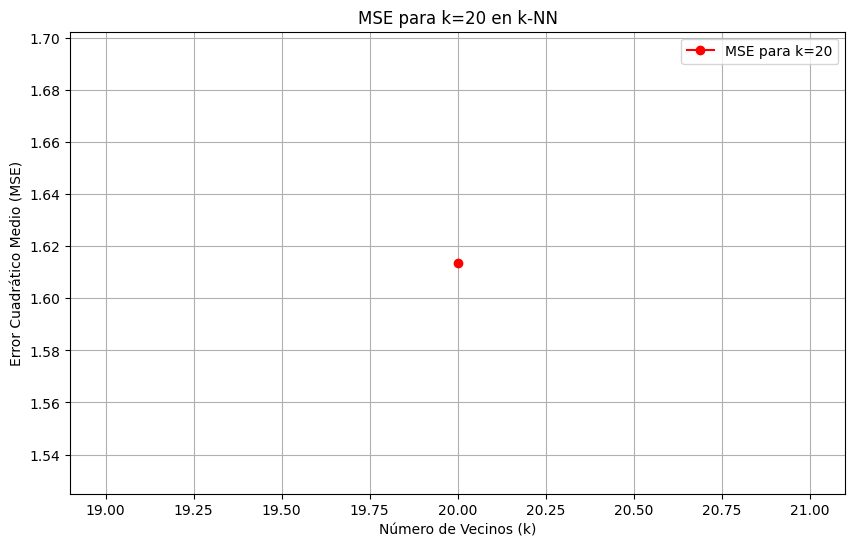

In [ ]:
# Definimos el valor de k que queremos evaluar (k=20)
k_value = 20

# Creamos el modelo de k-NN con k=20
knn = KNeighborsRegressor(n_neighbors=k_value)

# Entrenamos el modelo con los datos seleccionados
knn.fit(X_train, y_train)

# Predicciones y evaluación
y_pred = knn.predict(X_test)

# Evaluar rendimiento
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Resultados con k = {k_value}:")
print(f"Mean Squared Error con k={k_value}:", mse)
print(f"R-squared con k={k_value}:", r2)

# Si deseas graficar el MSE para k=20
plt.figure(figsize=(10, 6))
plt.plot([k_value], [mse], marker='o', color='r', label="MSE para k=20")
plt.xlabel('Número de Vecinos (k)')
plt.ylabel('Error Cuadrático Medio (MSE)')
plt.title('MSE para k=20 en k-NN')
plt.grid(True)
plt.legend()
plt.show()

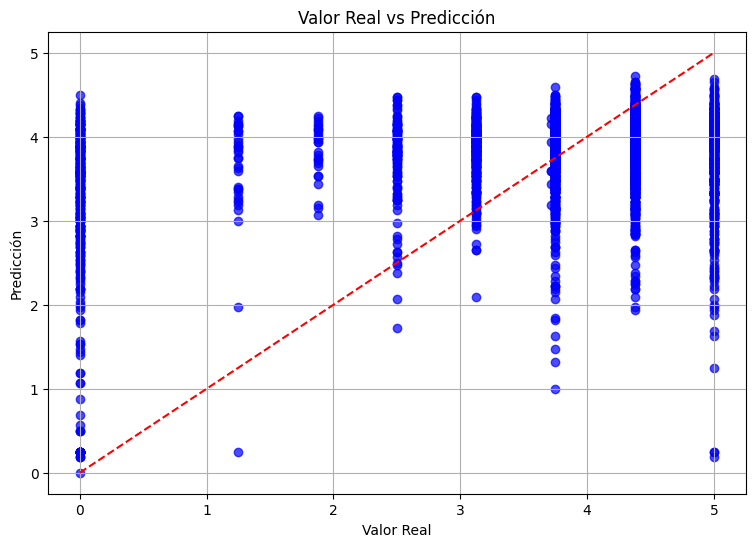

In [ ]:
#visualización de las predicciones:
plt.scatter(y_test, y_pred, alpha=0.7, color='b')
plt.plot([0, 5], [0, 5], color='r', linestyle='--')  # Línea de referencia
plt.xlabel('Valor Real')
plt.ylabel('Predicción')
plt.title('Valor Real vs Predicción')
plt.grid(True)
plt.show()

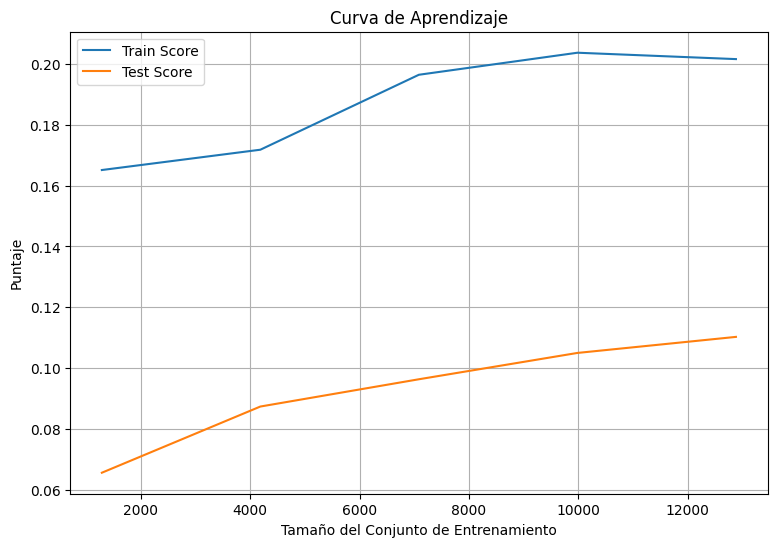

In [ ]:
#curva de aprendizaje
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(knn, X_train, y_train, cv=5)

plt.plot(train_sizes, np.mean(train_scores, axis=1), label="Train Score")
plt.plot(train_sizes, np.mean(test_scores, axis=1), label="Test Score")
plt.xlabel('Tamaño del Conjunto de Entrenamiento')
plt.ylabel('Puntaje')
plt.title('Curva de Aprendizaje')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#efecto MSE en reducir dimensionalidad
from sklearn.decomposition import PCA

pca = PCA(n_components=50)  # Reducimos a 50 dimensiones
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

model_pca = KNeighborsRegressor(n_neighbors=best_k)
model_pca.fit(X_train_pca, y_train)

y_pred_pca = model_pca.predict(X_test_pca)
mse_pca = mean_squared_error(y_test, y_pred_pca)
print(f"MSE tras PCA: {mse_pca:.4f}")

MSE tras PCA: 1.6090


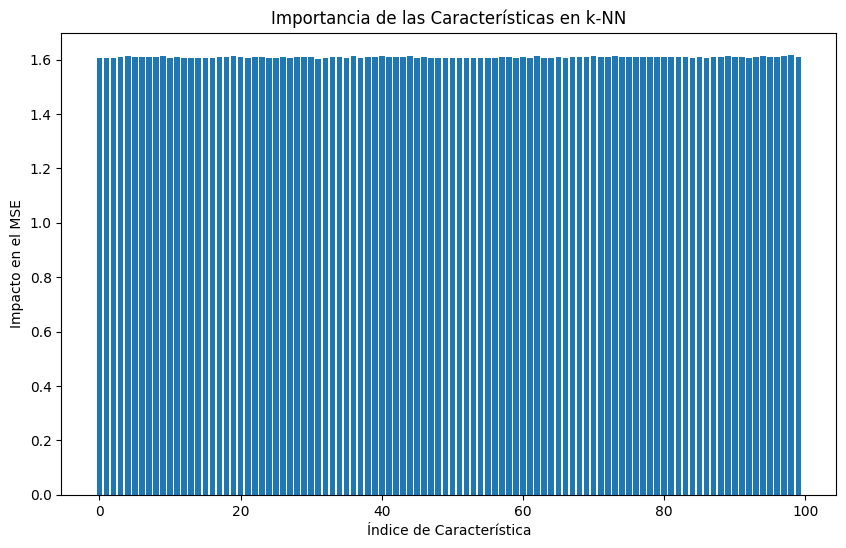

In [ ]:
#como varía modelo al reducir dimensionalidad:
importances = []
for i in range(X_train.shape[1]):
    X_train_temp = np.delete(X_train, i, axis=1)
    X_test_temp = np.delete(X_test, i, axis=1)

    model_temp = KNeighborsRegressor(n_neighbors=best_k)
    model_temp.fit(X_train_temp, y_train)
    y_pred_temp = model_temp.predict(X_test_temp)

    mse_temp = mean_squared_error(y_test, y_pred_temp)
    importances.append(mse_temp)

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances)
plt.xlabel("Índice de Característica")
plt.ylabel("Impacto en el MSE")
plt.title("Importancia de las Características en k-NN")
plt.show()

In [ ]:
#este histograma indica que el MSE permanece más o menos constante al eliminar cualquier dimensión: Indica que ninguna característica individual tiene un gran impacto en el rendimiento del modelo.

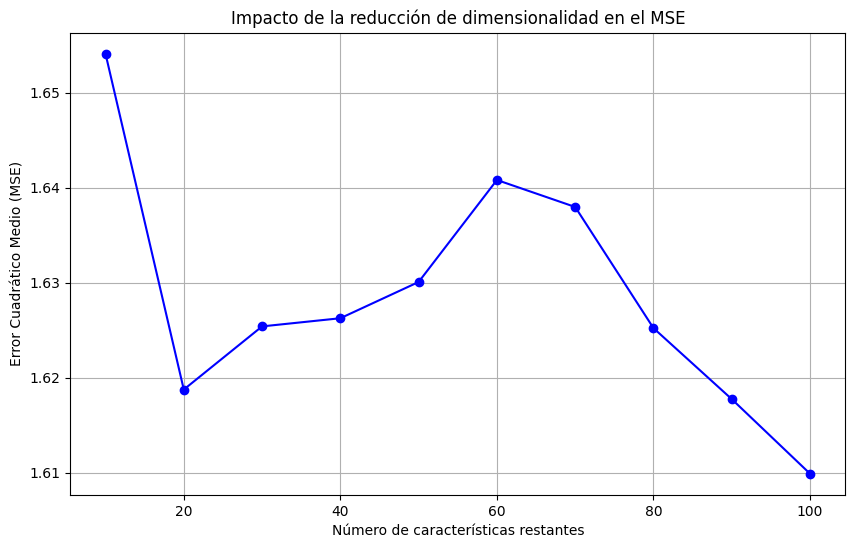

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Crear una lista para almacenar los resultados
mse_results = []
remaining_dimensions = []

# Número inicial de características
current_features = X_train.shape[1]

# Iterar eliminando progresivamente más características
for n_features_to_keep in range(current_features, 0, -10):  # Reducimos en pasos de 10
    # Seleccionar las n_features_to_keep características más relevantes (simular reducción)
    X_train_reduced = X_train[:, :n_features_to_keep]
    X_test_reduced = X_test[:, :n_features_to_keep]

    # Entrenar el modelo de k-NN con los datos reducidos
    model = KNeighborsRegressor(n_neighbors=best_k)
    model.fit(X_train_reduced, y_train)
    y_pred = model.predict(X_test_reduced)

    # Calcular el MSE
    mse = mean_squared_error(y_test, y_pred)
    mse_results.append(mse)
    remaining_dimensions.append(n_features_to_keep)

# Visualizar los resultados
plt.figure(figsize=(10, 6))
plt.plot(remaining_dimensions, mse_results, marker='o', color='blue')
plt.xlabel("Número de características restantes")
plt.ylabel("Error Cuadrático Medio (MSE)")
plt.title("Impacto de la reducción de dimensionalidad en el MSE")
plt.grid(True)
plt.show()